In [1]:
from Bio import Entrez, SeqIO
import pandas as pd
import numpy as np
import os

In [3]:
# Informing NCBI
Entrez.email = "hedwardes.ai@gmail.com"


In [4]:
# Search parameters
organism = "Mus musculus[Organism]"
gene = "Trp53[Gene]"
search_term = f"{organism} AND {gene}"

# Perform the search
handle = Entrez.esearch(db="nucleotide", term=search_term, retmax=100)
record = Entrez.read(handle)
handle.close()

# Get a list of GenBank IDs
genbank_ids = record["IdList"]
print(f"Found {len(genbank_ids)} records for {gene} in {organism}.")

Found 13 records for Trp53[Gene] in Mus musculus[Organism].


In [5]:
# Directory to save sequences
os.makedirs('sequences', exist_ok=True)

sequences = []

for genbank_id in genbank_ids:
    try:
        handle = Entrez.efetch(db="nucleotide", id=genbank_id, rettype="gb", retmode="text")
        seq_record = SeqIO.read(handle, "genbank")
        handle.close()
        sequences.append(seq_record)
        # Save each sequence to a FASTA file
        SeqIO.write(seq_record, f"sequences/{seq_record.id}.fasta", "fasta")
        print(f"Retrieved and saved: {seq_record.id}, Length: {len(seq_record.seq)}")
    except Exception as e:
        print(f"An error occurred while retrieving {genbank_id}: {e}")

Retrieved and saved: NM_001127233.2, Length: 1824
Retrieved and saved: NM_011640.4, Length: 1728
Retrieved and saved: XM_030245923.2, Length: 2031
Retrieved and saved: XM_006533157.5, Length: 2136
Retrieved and saved: NC_000077.7, Length: 121973369
Retrieved and saved: XM_030245922.1, Length: 1881
Retrieved and saved: CH466601.1, Length: 7647059
Retrieved and saved: AF367373.1, Length: 1502
Retrieved and saved: CM000219.2, Length: 132665419
Retrieved and saved: BC005448.1, Length: 1782
Retrieved and saved: AY044188.1, Length: 1176
Retrieved and saved: AL731687.13, Length: 116898
Retrieved and saved: EU031806.1, Length: 1250


In [10]:
# Pre-Processing

# Filter sequences based on length and content
min_length = 500  # Define minimum acceptable sequence length
clean_sequences = []

for seq_record in sequences:
    sequence = str(seq_record.seq).upper()
    if len(sequence) >= min_length and 'N' not in sequence:
        clean_sequences.append(seq_record)
    else:
        print(f"Sequence {seq_record.id} excluded due to insufficient length or ambiguous nucleotides.")

print(f"Number of clean sequences: {len(clean_sequences)}")

Sequence NC_000077.7 excluded due to insufficient length or ambiguous nucleotides.
Sequence CH466601.1 excluded due to insufficient length or ambiguous nucleotides.
Sequence CM000219.2 excluded due to insufficient length or ambiguous nucleotides.
Number of clean sequences: 10


In [12]:
# Extract Coding Sequences (CDS) as mutations in the coding regions are more likely to affect gene function.

# Create a dictionary mapping sequence IDs to their sequences
references = {record.id: record.seq for record in clean_sequences}

cds_sequences = []

for seq_record in clean_sequences:
    for feature in seq_record.features:
        if feature.type == "CDS":
            try:
                # Provide the references dictionary to handle referenced sequences
                cds_seq = feature.extract(seq_record.seq, references=references)
                cds_sequences.append({
                    'id': seq_record.id,
                    'sequence': str(cds_seq),
                    'description': seq_record.description
                })
            except ValueError as e:
                print(f"Skipping feature in {seq_record.id} due to error: {e}")

print(f"Number of CDS sequences extracted: {len(cds_sequences)}")


Skipping feature in AL731687.13 due to error: Feature references another sequence (AL596125.27), not found in references
Skipping feature in AL731687.13 due to error: Feature references another sequence (AL603707.5), not found in references
Number of CDS sequences extracted: 17


In [13]:
# Convert to DataFrame
df_sequences = pd.DataFrame(cds_sequences)
print(df_sequences.head())

               id                                           sequence  \
0  NM_001127233.2  ATGACTGCCATGGAGGAGTCACAGTCGGATATCAGCCTCGAGCTCC...   
1     NM_011640.4  ATGACTGCCATGGAGGAGTCACAGTCGGATATCAGCCTCGAGCTCC...   
2  XM_030245923.2  ATGACTGCCATGGAGGAGTCACAGTCGGATATCAGCCTCGAGCTCC...   
3  XM_006533157.5  ATGACTGCCATGGAGGAGTCACAGTCGGATATCAGCCTCGAGCTCC...   
4  XM_030245922.1  ATGACTGCCATGGAGGAGTCACAGTCGGATATCAGCCTCGAGCTCC...   

                                         description  
0  Mus musculus transformation related protein 53...  
1  Mus musculus transformation related protein 53...  
2  PREDICTED: Mus musculus transformation related...  
3  PREDICTED: Mus musculus transformation related...  
4  PREDICTED: Mus musculus transformation related...  


In [14]:
def assign_label(description):
    description_lower = description.lower()
    if "mutant" in description_lower or "mutation" in description_lower or "variant" in description_lower:
        return 1  # Mutated
    else:
        return 0  # Normal

df_sequences['label'] = df_sequences['description'].apply(assign_label)

# Check label distribution
print(df_sequences['label'].value_counts())

label
0    12
1     5
Name: count, dtype: int64


In [16]:
import numpy as np

# Mapping nucleotides to integers
nucleotide_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

def one_hot_encode_sequence(seq):
    integer_encoded = [nucleotide_to_int[base] for base in seq if base in nucleotide_to_int]
    one_hot_encoded = np.zeros((len(integer_encoded), 4), dtype=np.float32)
    one_hot_encoded[np.arange(len(integer_encoded)), integer_encoded] = 1
    return one_hot_encoded

# Apply encoding to all sequences
df_sequences['encoded_sequence'] = df_sequences['sequence'].apply(one_hot_encode_sequence)

In [17]:
# Determine maximum sequence length
max_length = 1000  # You can adjust this based on your data

# Pad or truncate sequences
def pad_sequence(seq, max_length):
    if len(seq) >= max_length:
        return seq[:max_length]
    else:
        padding = np.zeros((max_length - len(seq), 4), dtype=np.float32)
        return np.vstack([seq, padding])

df_sequences['padded_sequence'] = df_sequences['encoded_sequence'].apply(lambda x: pad_sequence(x, max_length))

In [18]:
import torch

# Stack sequences into a single numpy array
X = np.stack(df_sequences['padded_sequence'].values)
y = df_sequences['label'].values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y, dtype=torch.long)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

In [20]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class DNAClassifier(nn.Module):
    def __init__(self):
        super(DNAClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=8)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=8)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(31232, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # Exclude batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Instantiate the model
model = DNAClassifier()

In [26]:
def compute_output_length(input_length, kernel_size, padding=0, stride=1, dilation=1):
    return ((input_length + 2*padding - dilation*(kernel_size - 1) - 1) // stride) + 1

# After first conv and pool
length1 = compute_output_length(max_length, 8)
length1 = compute_output_length(length1, 2, stride=2)

# After second conv and pool
length2 = compute_output_length(length1, 8)
length2 = compute_output_length(length2, 2, stride=2)

# Calculate the input features for fc1
input_features_fc1 = length2 * 128  # 128 is the number of output channels from conv2

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [28]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_predictions / len(train_dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 1/50, Loss: 0.7026, Accuracy: 0.3077
Epoch 2/50, Loss: 0.6420, Accuracy: 0.6923
Epoch 3/50, Loss: 0.6126, Accuracy: 0.6923
Epoch 4/50, Loss: 0.5459, Accuracy: 0.6923
Epoch 5/50, Loss: 0.4690, Accuracy: 0.6923
Epoch 6/50, Loss: 0.4967, Accuracy: 0.6923
Epoch 7/50, Loss: 0.4827, Accuracy: 0.6923
Epoch 8/50, Loss: 0.4684, Accuracy: 0.6923
Epoch 9/50, Loss: 0.4173, Accuracy: 0.8462
Epoch 10/50, Loss: 0.5341, Accuracy: 0.6154
Epoch 11/50, Loss: 0.4790, Accuracy: 0.6154
Epoch 12/50, Loss: 0.3428, Accuracy: 0.9231
Epoch 13/50, Loss: 0.3966, Accuracy: 0.7692
Epoch 14/50, Loss: 0.3913, Accuracy: 0.8462
Epoch 15/50, Loss: 0.4113, Accuracy: 0.7692
Epoch 16/50, Loss: 0.4492, Accuracy: 0.6154
Epoch 17/50, Loss: 0.4118, Accuracy: 0.7692
Epoch 18/50, Loss: 0.4015, Accuracy: 0.7692
Epoch 19/50, Loss: 0.4220, Accuracy: 0.6154
Epoch 20/50, Loss: 0.3947, Accuracy: 0.6154
Epoch 21/50, Loss: 0.4390, Accuracy: 0.5385
Epoch 22/50, Loss: 0.4461, Accuracy: 0.7692
Epoch 23/50, Loss: 0.3229, Accuracy: 0.76

In [29]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 1.0000


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         3
     Mutated       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



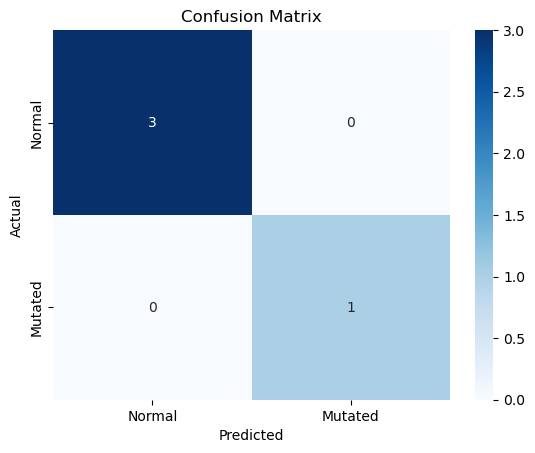

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Mutated']))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Mutated'], yticklabels=['Normal', 'Mutated'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [32]:
torch.save(model.state_dict(), 'dna_classifier_model.pth')

# Instantiate the model
model = DNAClassifier()
model.load_state_dict(torch.load('dna_classifier_model.pth'))
model.to(device)

C:\Users\harry\AppData\Local\Temp\ipykernel_46796\3744730301.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('dna_classifier_model.pth')

DNAClassifier(
  (conv1): Conv1d(4, 64, kernel_size=(8,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=31232, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)